# Предсказание CTR 2018

https://www.kaggle.com/c/babushka-ctr-2018

Описание файлов

Вам представлены данные поисковых запросов, по которым была показана контекстная реклама одного рекламодателя.

    train.csv - the training set
    test.csv - the test set.

Поля данных

    RowId - идшник для сабмишена
    AveragePosition - средняя позиция объявления на странице выдачи
    CampaignId - рекламная кампания, обычно содежит объявления одной тематики
    AdGroupId  - содержит группу объявлений, которые показываются при совпадении запроса пользователя (Query) с ключевым словом рекламодателя (описывается KeywordId, сами ключевые слова не включены в датасет)


In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score, train_test_split
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [97]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test_upd.csv")

Переделаем дату в datetime и посчитаем, сколько было сделано и не сделано кликов

In [98]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
train['NotClicks'] = train['Impressions'] - train['Clicks']
train.drop(['Impressions'], axis=1, inplace=True)

Посмотрим на данные

In [99]:
train.head()

,CampaignId,AdGroupId,KeywordId,Query,QueryMatchTypeWithVariant,Device,Date,AveragePosition,Clicks,NotClicks
0,150950690,7953835370,116881275,may loan,NEAR_EXACT,HIGH_END_MOBILE,2016-08-26,1.0,1,0
1,150950690,7953835370,116881275,my lloan,NEAR_EXACT,DESKTOP,2016-09-16,1.0,1,0
2,150950690,7953835370,116881275,my loan,EXACT,DESKTOP,2016-04-05,2.0,1,0
3,150950690,7953835370,116881275,my loan,EXACT,DESKTOP,2016-04-12,2.0,1,0
4,150950690,7953835370,116881275,my loan,EXACT,DESKTOP,2016-04-18,1.0,0,1


Перейдем к бинарной классификации. Для этого размножим строки в количестве равном Clicks и NotClicks с соответствующим классом 0 или 1

In [100]:
def reproduce_rows(df):        
    for i, *row, clicks, not_clicks in df.itertuples():
        while clicks > 0:
            yield row + [1]
            clicks -= 1
        while not_clicks > 0:
            yield row + [0]
            not_clicks -= 1
            
columns = list(train.columns.values)   
columns.remove('NotClicks')
train = pd.DataFrame([*reproduce_rows(train)], columns=columns)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569532 entries, 0 to 569531
Data columns (total 9 columns):
CampaignId                   569532 non-null int64
AdGroupId                    569532 non-null int64
KeywordId                    569532 non-null int64
Query                        569532 non-null object
QueryMatchTypeWithVariant    569532 non-null object
Device                       569532 non-null object
Date                         569532 non-null datetime64[ns]
AveragePosition              569532 non-null float64
Clicks                       569532 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 39.1+ MB


Посмотрим на соотношение этих кликов

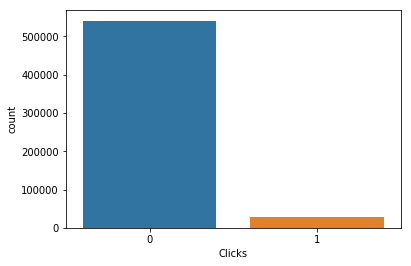

In [101]:
sns.countplot(x="Clicks", data=train)

Посмотрим на данные по кампаниям

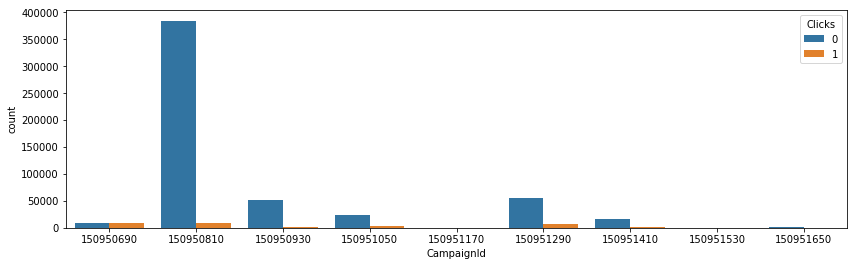

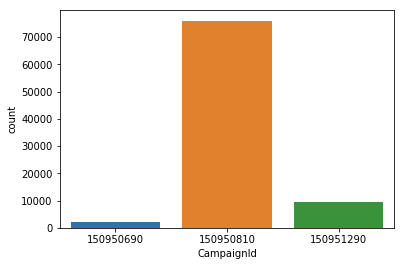

In [102]:
plt.figure(figsize=(14,4))
sns.countplot(x="CampaignId", data=train, hue=train['Clicks'])
plt.show()
sns.countplot(x="CampaignId", data=test)
plt.show()

In [103]:
pd.crosstab(train.CampaignId, train.Clicks, normalize='index')

Clicks,0,1
CampaignId,,
150950690,0.490736,0.509264
150950810,0.979082,0.020918
150950930,0.984000,0.016000
150951050,0.895692,0.104308
150951170,0.732955,0.267045
150951290,0.887885,0.112115
150951410,0.954277,0.045723
150951530,0.936605,0.063395
150951650,0.813084,0.186916


Можно заметить, что в трейновой выборке 9 кампаний, в тестовой 3, причем эти три являются подмножеством кампаний из трейновой. Придется выпилить все кампании не из теста. Кроме того, по рекламам кампании 150950690 наблюдается явная аномалия: количество кликов даже немного больше чем количество "некликов". Посмотрим, по каким запросам она показывается

In [104]:
train = train.loc[train['CampaignId'].isin([150950690, 150950810, 150951290])]
interest_campaign = train.loc[train['CampaignId'] == 150950690]
interest_campaign['Query'].value_counts()[:10]

myloan             11564
my loan             2210
mylan               1401
my loan sverige      265
myloan se            231
mylån                203
www myloan se        159
my lån               132
myloan omdöme        131
mylone               113
Name: Query, dtype: int64

Люди ищут какой-то MyLoan, видимо какие-то кредиты ¯\_(ツ)_/¯

Вообще судя по данным, столбец Query кодируется ключом из столбца KeywordId и точностью его написания QueryMatchTypeWithVariant, так что его можно скипнуть. Взглянем как раз на QueryMatchTypeWithVariant

Clicks,0,1
QueryMatchTypeWithVariant,,
EXACT,0.962038,0.037962
EXPANDED,0.877733,0.122267
NEAR_EXACT,0.814298,0.185702
NEAR_PHRASE,0.734168,0.265832
PHRASE,0.885723,0.114277


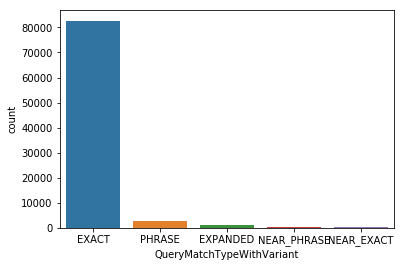

In [105]:
sns.countplot(x="QueryMatchTypeWithVariant", data=test)
pd.crosstab(train.QueryMatchTypeWithVariant, train.Clicks, normalize='index')

Здесь никаких аномалий - по точному вводу кликают чаще и показывается она чаще, по приблизительной фразе кликают реже. Реже всего кликают по Expanded и Phrase, посмотрим, что такое Expanded

In [106]:
train.loc[train['QueryMatchTypeWithVariant'] == 'EXPANDED']

,CampaignId,AdGroupId,KeywordId,Query,QueryMatchTypeWithVariant,Device,Date,AveragePosition,Clicks
12496,150950690,7953835370,44520786825,how much housing loan i can get for my salary,EXPANDED,DESKTOP,2016-09-05,1.0,1
12501,150950690,7953835370,44520786825,loan money to my paypal account,EXPANDED,DESKTOP,2016-01-19,1.0,1
12502,150950690,7953835370,44520786825,loan money to my paypal account,EXPANDED,DESKTOP,2016-01-29,1.0,1
12503,150950690,7953835370,44520786825,loan money to my paypal account,EXPANDED,DESKTOP,2016-01-29,1.0,0
12504,150950690,7953835370,44520786825,loan money to my paypal account,EXPANDED,DESKTOP,2016-01-29,1.0,0
12505,150950690,7953835370,44520786825,loan money to my paypal account,EXPANDED,DESKTOP,2016-01-29,1.0,0
12513,150950690,7953835370,44520786825,my car loan,EXPANDED,DESKTOP,2016-01-08,1.0,1
12514,150950690,7953835370,44520786825,my car loan,EXPANDED,DESKTOP,2016-02-03,1.0,0
12515,150950690,7953835370,44520786825,my car loan,EXPANDED,DESKTOP,2016-04-21,1.0,1
12516,150950690,7953835370,44520786825,my car loan,EXPANDED,DESKTOP,2016-04-22,1.0,1


Судя по всему, это запросы, подходящие под тематику рекламы.

Посмотрим на девайсы

Clicks,0,1
Device,,
DESKTOP,0.940015,0.059985
HIGH_END_MOBILE,0.960679,0.039321
TABLET,0.936681,0.063319


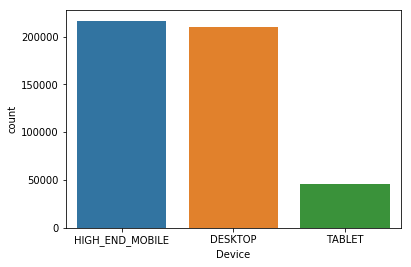

In [107]:
sns.countplot(x="Device", data=train)
pd.crosstab(train.Device, train.Clicks, normalize='index')

Ну тут примерно все одинаково

Средняя позиция вроде как очевидно должна кореллировать с количеством кликов, проверим

Clicks,0,1
AveragePosition,,
1.0,0.787459,0.212541
1.1,0.810670,0.189330
1.2,0.854409,0.145591
1.3,0.878857,0.121143
1.4,0.917642,0.082358
1.5,0.883038,0.116962
1.6,0.948627,0.051373
1.7,0.908412,0.091588
1.8,0.950460,0.049540


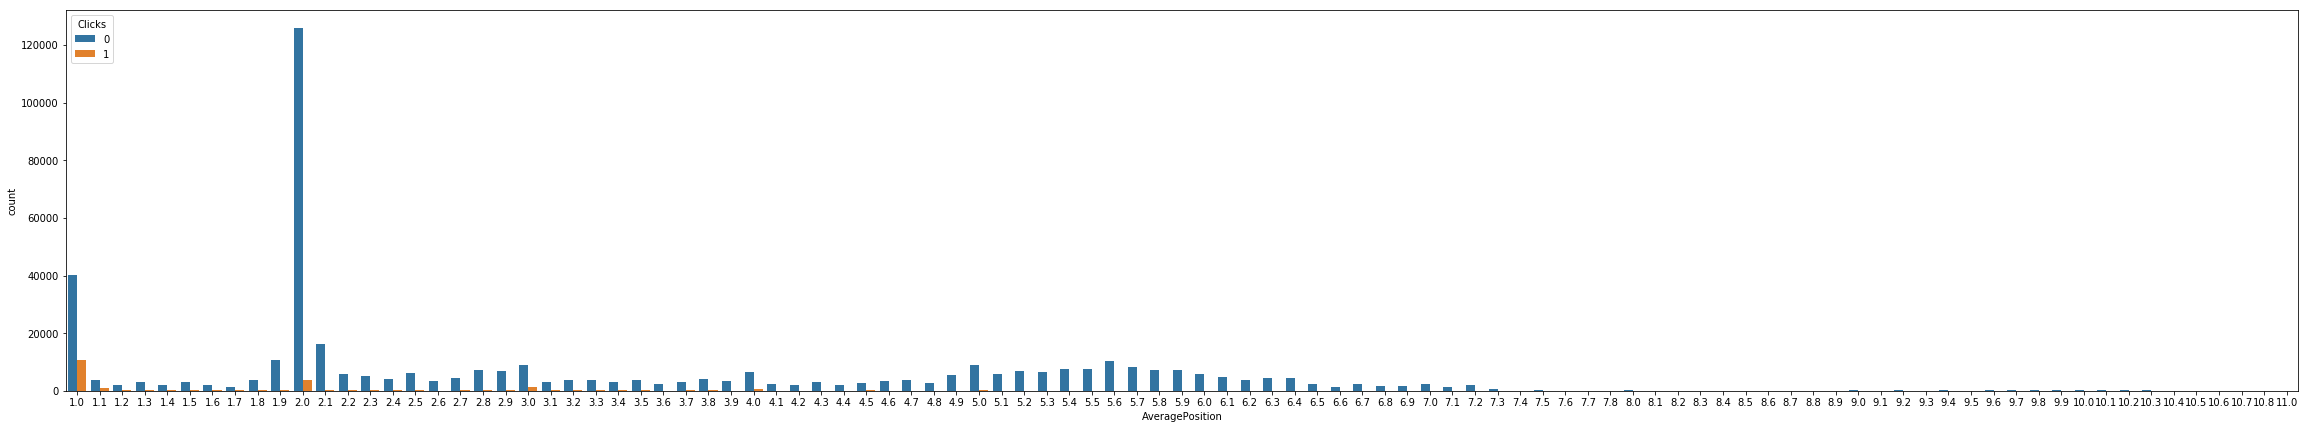

In [108]:
plt.figure(figsize=(40,7))
sns.countplot(x="AveragePosition", data=train, hue='Clicks')
pd.crosstab(train.AveragePosition, train.Clicks, normalize='index')

По сути так и есть. Разберемся со временем

In [109]:
print(train.Date.describe(), '\n', test.Date.describe())

count                  472023
unique                    363
top       2016-06-27 00:00:00
freq                     4826
first     2016-01-01 00:00:00
last      2016-12-31 00:00:00
Name: Date, dtype: object 
 count                   87807
unique                     50
top       2017-02-01 00:00:00
freq                     2869
first     2017-01-01 00:00:00
last      2017-02-19 00:00:00
Name: Date, dtype: object


Интересно посмотреть, как зависит CTR от дня недели

In [110]:
train['Day_of_week'] = train['Date'].apply(lambda day: day.weekday_name)
test['Day_of_week'] = test['Date'].apply(lambda day: day.weekday_name)
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

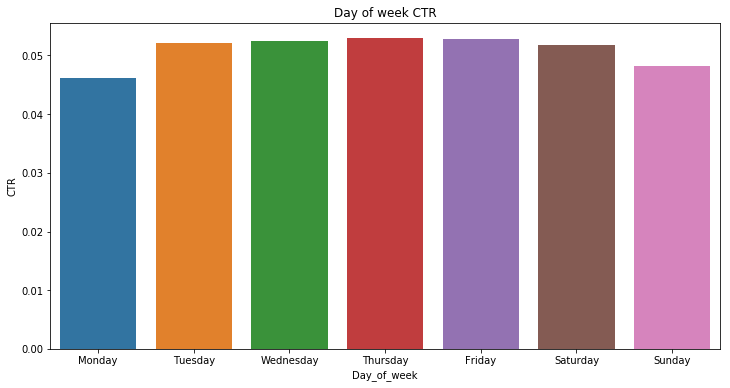

In [111]:
df_click = train[train['Clicks'] == 1]
df_dayofweek = train[['Day_of_week','Clicks']].groupby(['Day_of_week']).count().reset_index()
df_dayofweek = df_dayofweek.rename(columns={'Clicks': 'impressions'})
df_dayofweek['Clicks'] = df_click[['Day_of_week','Clicks']].groupby(['Day_of_week']).count().reset_index()['Clicks']
df_dayofweek['CTR'] = df_dayofweek['Clicks']/df_dayofweek['impressions']
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='Day_of_week', data=df_dayofweek, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Day of week CTR');

Прямо скажем не сильно отличается, но как фичу можно оставить

Заэнкодим категориальные переменные (если быть честным, они тут все, кроме кликов и показов, категориальные, но речь про
категориальные-текстовые)

In [112]:
train['train'] = 1
test['train'] = 0
combined = pd.concat([train, test])
combined= pd.get_dummies(combined, columns=["QueryMatchTypeWithVariant", 'AdGroupId',
                                      "Device", 'CampaignId', 'KeywordId', 'Query', 'Day_of_week'])
train = combined[combined['train'] == 1]
test = combined[combined['train'] == 0]
train.drop(['train'], axis=1, inplace=True)
test.drop(['train'], axis=1, inplace=True)

Функция для сохранения результата

In [113]:
def save_prediction(prediction, file_name):
    pd.DataFrame({"Id":list(range(0, 87807)),"ClickProbability":prediction}).to_csv(file_name,
                                                                                          index=False,header=True)

Для обучения возьмем первые 10 месяцев, для валидации последние два (данные даны за календарный 2016 год)

In [114]:
X_train = train.loc[train['Date'] < '2016-10-1']
X_val = train.loc[train['Date'] >= '2016-10-1']

In [115]:
print(X_train.Date.describe(), '\n', X_val.Date.describe())

count                  369445
unique                    271
top       2016-06-27 00:00:00
freq                     4826
first     2016-01-01 00:00:00
last      2016-09-30 00:00:00
Name: Date, dtype: object 
 count                  102578
unique                     92
top       2016-10-10 00:00:00
freq                     2753
first     2016-10-01 00:00:00
last      2016-12-31 00:00:00
Name: Date, dtype: object


In [116]:
X_train.drop(["Date"], axis=1, inplace=True)
X_val.drop(["Date"], axis=1, inplace=True)
test.drop(["Date", "Id"], axis=1, inplace=True)

In [117]:
y_train = X_train['Clicks']
y_val = X_val['Clicks']
X_train.drop(['Clicks'], axis=1, inplace=True)
X_val.drop(['Clicks'], axis=1, inplace=True)

In [118]:
import lightgbm as lgb
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [119]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': { 'binary_logloss'},
    'num_leaves': 31,
    'learning_rate': 0.08,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.3,
    'bagging_freq': 5,
    'verbose': 0
}

print('Start training...')

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=4000,
                valid_sets=lgb_eval,
                early_stopping_rounds=500)

Start training...
[1]	valid_0's binary_logloss: 0.228914
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's binary_logloss: 0.216554
[3]	valid_0's binary_logloss: 0.208017
[4]	valid_0's binary_logloss: 0.201721
[5]	valid_0's binary_logloss: 0.196797
[6]	valid_0's binary_logloss: 0.192563
[7]	valid_0's binary_logloss: 0.189279
[8]	valid_0's binary_logloss: 0.186533
[9]	valid_0's binary_logloss: 0.184078
[10]	valid_0's binary_logloss: 0.181962
[11]	valid_0's binary_logloss: 0.180404
[12]	valid_0's binary_logloss: 0.178763
[13]	valid_0's binary_logloss: 0.177374
[14]	valid_0's binary_logloss: 0.176124
[15]	valid_0's binary_logloss: 0.175097
[16]	valid_0's binary_logloss: 0.174231
[17]	valid_0's binary_logloss: 0.173489
[18]	valid_0's binary_logloss: 0.172697
[19]	valid_0's binary_logloss: 0.172003
[20]	valid_0's binary_logloss: 0.171439
[21]	valid_0's binary_logloss: 0.171012
[22]	valid_0's binary_logloss: 0.1707
[23]	valid_0's binary_logloss: 0.170356
[24]	valid

[206]	valid_0's binary_logloss: 0.164065
[207]	valid_0's binary_logloss: 0.163974
[208]	valid_0's binary_logloss: 0.163916
[209]	valid_0's binary_logloss: 0.163813
[210]	valid_0's binary_logloss: 0.163821
[211]	valid_0's binary_logloss: 0.163736
[212]	valid_0's binary_logloss: 0.163665
[213]	valid_0's binary_logloss: 0.163628
[214]	valid_0's binary_logloss: 0.163598
[215]	valid_0's binary_logloss: 0.163559
[216]	valid_0's binary_logloss: 0.163575
[217]	valid_0's binary_logloss: 0.163555
[218]	valid_0's binary_logloss: 0.163614
[219]	valid_0's binary_logloss: 0.163636
[220]	valid_0's binary_logloss: 0.163627
[221]	valid_0's binary_logloss: 0.163679
[222]	valid_0's binary_logloss: 0.16366
[223]	valid_0's binary_logloss: 0.163658
[224]	valid_0's binary_logloss: 0.163659
[225]	valid_0's binary_logloss: 0.163677
[226]	valid_0's binary_logloss: 0.163669
[227]	valid_0's binary_logloss: 0.163673
[228]	valid_0's binary_logloss: 0.163666
[229]	valid_0's binary_logloss: 0.16368
[230]	valid_0's bi

[410]	valid_0's binary_logloss: 0.164535
[411]	valid_0's binary_logloss: 0.164538
[412]	valid_0's binary_logloss: 0.16454
[413]	valid_0's binary_logloss: 0.16451
[414]	valid_0's binary_logloss: 0.1645
[415]	valid_0's binary_logloss: 0.164525
[416]	valid_0's binary_logloss: 0.164535
[417]	valid_0's binary_logloss: 0.164514
[418]	valid_0's binary_logloss: 0.164516
[419]	valid_0's binary_logloss: 0.164526
[420]	valid_0's binary_logloss: 0.164495
[421]	valid_0's binary_logloss: 0.164524
[422]	valid_0's binary_logloss: 0.164527
[423]	valid_0's binary_logloss: 0.164583
[424]	valid_0's binary_logloss: 0.164607
[425]	valid_0's binary_logloss: 0.164622
[426]	valid_0's binary_logloss: 0.164581
[427]	valid_0's binary_logloss: 0.164615
[428]	valid_0's binary_logloss: 0.164591
[429]	valid_0's binary_logloss: 0.164562
[430]	valid_0's binary_logloss: 0.16455
[431]	valid_0's binary_logloss: 0.164541
[432]	valid_0's binary_logloss: 0.164542
[433]	valid_0's binary_logloss: 0.164582
[434]	valid_0's binar

[615]	valid_0's binary_logloss: 0.164842
[616]	valid_0's binary_logloss: 0.164805
[617]	valid_0's binary_logloss: 0.16479
[618]	valid_0's binary_logloss: 0.164813
[619]	valid_0's binary_logloss: 0.164819
[620]	valid_0's binary_logloss: 0.164824
[621]	valid_0's binary_logloss: 0.164778
[622]	valid_0's binary_logloss: 0.164778
[623]	valid_0's binary_logloss: 0.164744
[624]	valid_0's binary_logloss: 0.16472
[625]	valid_0's binary_logloss: 0.164685
[626]	valid_0's binary_logloss: 0.164727
[627]	valid_0's binary_logloss: 0.164746
[628]	valid_0's binary_logloss: 0.16475
[629]	valid_0's binary_logloss: 0.164768
[630]	valid_0's binary_logloss: 0.164792
[631]	valid_0's binary_logloss: 0.164804
[632]	valid_0's binary_logloss: 0.164747
[633]	valid_0's binary_logloss: 0.164716
[634]	valid_0's binary_logloss: 0.16466
[635]	valid_0's binary_logloss: 0.164635
[636]	valid_0's binary_logloss: 0.164635
[637]	valid_0's binary_logloss: 0.164631
[638]	valid_0's binary_logloss: 0.164622
[639]	valid_0's bina

In [120]:
print(gbm.best_score)
print(gbm.best_iteration)

defaultdict(<class 'dict'>, {'valid_0': {'binary_logloss': 0.1635545100667544}})
217


In [121]:
labels = gbm.predict(test)

In [122]:
print(labels)

[0.04782505 0.1237419  0.00554532 ... 0.06508157 0.04344145 0.00597964]


Посмотрим на самые важные фичи

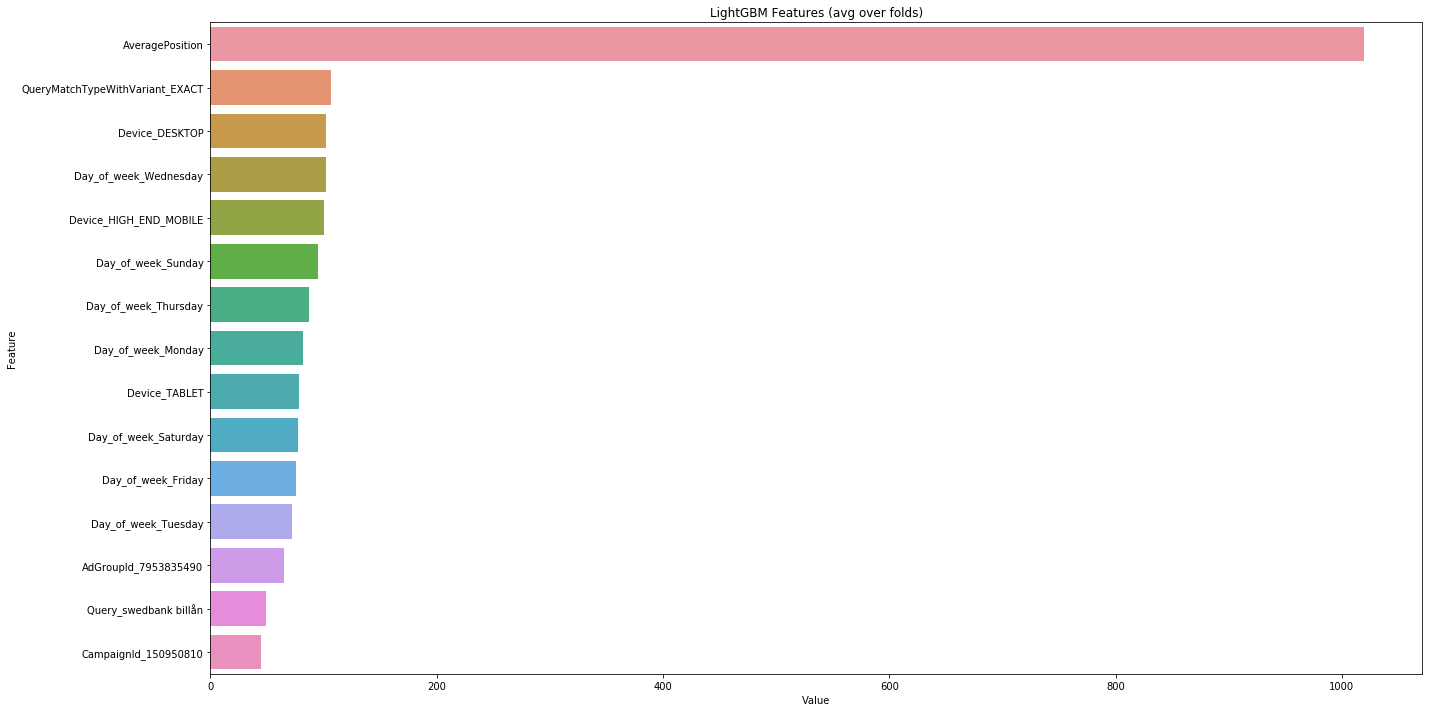

In [125]:
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(), X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

Как и ожидалось, решает позиция

Теперь обучимся на всей выборке

In [127]:
y = train['Clicks']
train.drop(['Clicks', 'Date'], axis=1, inplace=True)

In [128]:
lgb_train = lgb.Dataset(train, y)

In [131]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': { 'binary_logloss'},
    'num_leaves': 31,
    'learning_rate': 0.08,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.3,
    'bagging_freq': 5,
    'verbose': 0,
    'num_iterations': gbm.best_iteration
}

print('Start training...')

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=4000)

Start training...


In [132]:
labels = gbm.predict(test)
print(labels)

[0.0357255  0.09622258 0.00603407 ... 0.0718951  0.044793   0.00557286]


In [133]:
save_prediction(labels, 'lgbm.csv')

Получаем следующие результаты:

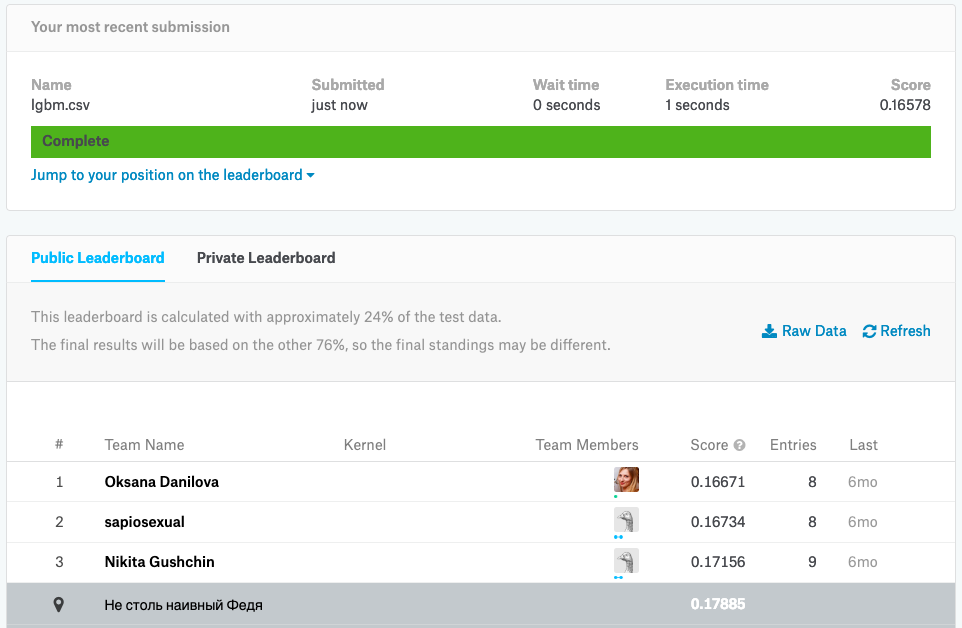

In [144]:
from IPython.display import Image
Image(filename='public_score.png')

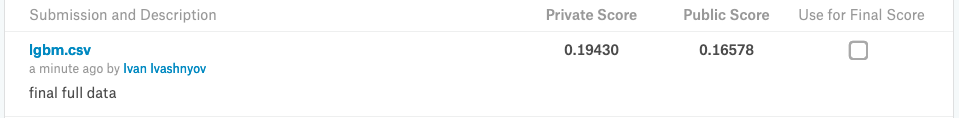

In [145]:
Image(filename='scores.png')